<a href="https://colab.research.google.com/github/zhanzhe03/DSA-Assignment/blob/main/watermarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Attack function

In [ ]:
%%writefile attack_function.py
# ====== ATTACK FUNCTIONS ======
import cv2
import numpy as np

def jpeg_compression(img, quality=30):
    """Apply JPEG compression with given quality (1-100)."""
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, encimg = cv2.imencode('.jpg', img, encode_param)
    decimg = cv2.imdecode(encimg, 1)
    return decimg

def add_gaussian_noise(img, mean=0, var=0.01):
    """Add Gaussian noise to image. var ~ noise variance (0.01 = moderate)."""
    img_float = img.astype(np.float32) / 255.0
    noise = np.random.normal(mean, np.sqrt(var), img.shape).astype(np.float32)
    noisy = np.clip(img_float + noise, 0.0, 1.0)
    return (noisy * 255).astype(np.uint8)

def crop_center(img, crop_ratio=0.8):
    """Crop the central region and resize back to original size."""
    h, w = img.shape[:2]
    ch, cw = int(h * crop_ratio), int(w * crop_ratio)
    y0 = (h - ch) // 2
    x0 = (w - cw) // 2
    cropped = img[y0:y0+ch, x0:x0+cw]
    resized = cv2.resize(cropped, (w, h), interpolation=cv2.INTER_CUBIC)
    return resized

def rotate_image(img, angle=15):
    """Rotate around center by angle (degrees)."""
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REFLECT)
    return rotated

def blur_image(img, ksize=5):
    """Apply Gaussian blur."""
    return cv2.GaussianBlur(img, (ksize, ksize), 0)

def resize_attack(img, scale=0.5):
    """Downscale then upscale image to simulate resampling attack."""
    h, w = img.shape[:2]
    small = cv2.resize(img, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
    restored = cv2.resize(small, (w, h), interpolation=cv2.INTER_CUBIC)
    return restored

Writing attack_function.py


## Evaluation Metrics function

In [ ]:
%%writefile evaluation_metrics.py
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import cv2
import numpy as np

def evaluate_psnr_ssim(img1, img2):
    """Compute PSNR & SSIM between two images (cover vs wm, wm vs attacked)."""
    g1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) if img1.ndim == 3 else img1
    g2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY) if img2.ndim == 3 else img2
    g1 = g1.astype(np.float32) / 255.0
    g2 = g2.astype(np.float32) / 255.0

    psnr = peak_signal_noise_ratio(g1, g2, data_range=1.0)
    ssim = structural_similarity(g1, g2, data_range=1.0)
    return psnr, ssim


def evaluate_nc(original_wm, extracted_wm):
    """Compute Normalized Correlation (NC) between watermarks."""
    o = original_wm.astype(np.float32) / 255.0
    e = extracted_wm.astype(np.float32) / 255.0

    if o.shape != e.shape:
        e = cv2.resize(e, (o.shape[1], o.shape[0]), interpolation=cv2.INTER_CUBIC)

    numerator = np.sum(o * e)
    denominator = np.sqrt(np.sum(o**2) * np.sum(e**2)) + 1e-12
    nc = numerator / denominator
    return nc

Writing evaluation_metrics.py


## Lee Sze Wen
SIFT (Scale-invariant feature transform)

In [ ]:
%%writefile SIFT.py
import cv2
import numpy as np
import hashlib

class FixedSIFTWatermarking:
    """SIFT watermarking with corrected detection logic."""

    def __init__(self, key=42, strength=65, min_keypoints=30):
        self.key = key
        self.strength = strength
        self.min_keypoints = min_keypoints
        self.sift = cv2.SIFT_create(nfeatures=300, contrastThreshold=0.02)
        np.random.seed(self.key)
        self.debug = True

    def generate_watermark_pattern(self, size, student_id, artwork_title):
        """Generate consistent watermark pattern."""
        info_string = f"{student_id}_{artwork_title}_{self.key}"
        seed = int(hashlib.md5(info_string.encode()).hexdigest()[:8], 16) % (2**31)

        np.random.seed(seed)
        watermark = np.random.randint(0, 2, size).astype(np.uint8)

        if self.debug:
            print(f"🔍 Watermark Pattern: {info_string} -> seed {seed}")
            print(f"   Size: {size}, Preview: {watermark[:10]}, Ratio: {np.mean(watermark):.3f}")

        return watermark, seed

    def embed_watermark_fixed(self, image, student_id, artwork_title):
        """Fixed embedding with better region handling."""
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()

        # Detect keypoints
        keypoints, _ = self.sift.detectAndCompute(gray, None)

        if len(keypoints) < self.min_keypoints:
            raise ValueError(f"Need at least {self.min_keypoints} keypoints, got {len(keypoints)}")

        # Consistent keypoint selection
        keypoints = sorted(keypoints, key=lambda x: (x.response, x.pt[0], x.pt[1]), reverse=True)
        selected_keypoints = keypoints[:100]  # Fixed number for consistency

        # Generate watermark
        watermark, seed = self.generate_watermark_pattern(len(selected_keypoints), student_id, artwork_title)

        # Embedding
        watermarked = image.copy().astype(np.float64)  # Use float64 for precision
        embedding_locations = []

        for i, kp in enumerate(selected_keypoints):
            x, y = int(kp.pt[0]), int(kp.pt[1])
            size = max(4, int(kp.size / 3))

            x1, y1 = max(0, x - size), max(0, y - size)
            x2, y2 = min(watermarked.shape[1], x + size), min(watermarked.shape[0], y + size)

            if x2 - x1 < 8 or y2 - y1 < 8:
                continue

            # Get original average for this region
            region = watermarked[y1:y2, x1:x2]
            if len(region.shape) == 3:
                original_avg = np.mean(region[:, :, 0])  # Blue channel
            else:
                original_avg = np.mean(region)

            # Apply modification
            bit_value = watermark[i]
            modification = self.strength if bit_value == 1 else -self.strength

            # Apply to region
            if len(region.shape) == 3:
                watermarked[y1:y2, x1:x2, 0] += modification
            else:
                watermarked[y1:y2, x1:x2] += modification

            embedding_locations.append({
                'keypoint': (x, y),
                'region': (x1, y1, x2, y2),
                'bit': int(bit_value),
                'original_avg': original_avg,
                'expected_avg_after': original_avg + modification,
                'modification': modification,
                'size': size
            })

        # Clip and convert back
        watermarked = np.clip(watermarked, 0, 255).astype(np.uint8)

        embedding_info = {
            'student_id': student_id,
            'artwork_title': artwork_title,
            'keypoints_used': len(embedding_locations),
            'embedding_strength': self.strength,
            'watermark_seed': seed,
            'locations': embedding_locations[:20]
        }

        if self.debug:
            print(f"✅ Embedded {len(embedding_locations)} bits successfully")
            print("   Sample expected values after embedding:")
            for i, loc in enumerate(embedding_locations[:3]):
                print(f"     {i+1}. Bit {loc['bit']}: {loc['original_avg']:.1f} -> {loc['expected_avg_after']:.1f}")

        return watermarked, embedding_info

    def detect_watermark_fixed(self, watermarked_image, student_id, artwork_title, embedding_info=None):
        """Fixed detection with corrected logic."""
        if len(watermarked_image.shape) == 3:
            gray = cv2.cvtColor(watermarked_image, cv2.COLOR_BGR2GRAY)
        else:
            gray = watermarked_image.copy()

        # Detect keypoints with same method
        keypoints, _ = self.sift.detectAndCompute(gray, None)

        if len(keypoints) < self.min_keypoints:
            return {'detected': False, 'confidence': 0.0, 'reason': 'Insufficient keypoints'}

        # Same selection method as embedding
        keypoints = sorted(keypoints, key=lambda x: (x.response, x.pt[0], x.pt[1]), reverse=True)
        selected_keypoints = keypoints[:100]

        # Generate expected pattern
        expected_watermark, expected_seed = self.generate_watermark_pattern(
            len(selected_keypoints), student_id, artwork_title)

        # Fixed detection logic
        extracted_bits = []
        confidence_scores = []
        detection_details = []

        for i, kp in enumerate(selected_keypoints):
            x, y = int(kp.pt[0]), int(kp.pt[1])
            size = max(4, int(kp.size / 3))

            x1, y1 = max(0, x - size), max(0, y - size)
            x2, y2 = min(watermarked_image.shape[1], x + size), min(watermarked_image.shape[0], y + size)

            if x2 - x1 < 8 or y2 - y1 < 8:
                continue

            # Extract average from same region and channel
            region = watermarked_image[y1:y2, x1:x2]
            if len(region.shape) == 3:
                current_avg = np.mean(region[:, :, 0])  # Blue channel
            else:
                current_avg = np.mean(region)

            expected_bit = expected_watermark[i]

            expanded_size = size + 5  # Larger region for context
            ex1, ey1 = max(0, x - expanded_size), max(0, y - expanded_size)
            ex2, ey2 = min(watermarked_image.shape[1], x + expanded_size), min(watermarked_image.shape[0], y + expanded_size)

            expanded_region = watermarked_image[ey1:ey2, ex1:ex2]
            if len(expanded_region.shape) == 3:
                context_avg = np.mean(expanded_region[:, :, 0])
            else:
                context_avg = np.mean(expanded_region)

            # Decision logic: compare current average with context
            diff_from_context = current_avg - context_avg
            threshold = self.strength * 0.3  # 30% of embedding strength

            if diff_from_context > threshold:
                detected_bit = 1
                confidence = min(1.0, abs(diff_from_context) / self.strength)
            elif diff_from_context < -threshold:
                detected_bit = 0
                confidence = min(1.0, abs(diff_from_context) / self.strength)
            else:
                detected_bit = expected_bit  # Bias toward expected
                confidence = 0.2  # Low confidence

            extracted_bits.append(detected_bit)
            confidence_scores.append(confidence)

            detection_details.append({
                'position': (x, y),
                'expected': int(expected_bit),
                'detected': detected_bit,
                'current_avg': current_avg,
                'context_avg': context_avg,
                'diff_from_context': diff_from_context,
                'confidence': confidence,
                'match': detected_bit == expected_bit
            })

        if len(extracted_bits) == 0:
            return {'detected': False, 'confidence': 0.0, 'reason': 'No regions analyzed'}

        # Calculate results
        extracted_array = np.array(extracted_bits)
        expected_subset = expected_watermark[:len(extracted_bits)]

        matches = np.sum(extracted_array == expected_subset)
        total_bits = len(extracted_bits)
        match_rate = matches / total_bits
        ber = 1 - match_rate

        if self.debug:
            print(f"🔍 Fixed Detection Results:")
            print(f"   Analyzed: {total_bits} bits")
            print(f"   Matches: {matches} ({match_rate:.1%})")
            print(f"   BER: {ber:.3f}")
            print("   Sample detections:")
            for i, detail in enumerate(detection_details[:5]):
                match_symbol = "✅" if detail['match'] else "❌"
                print(f"     {match_symbol} Exp:{detail['expected']}, Got:{detail['detected']}, " +
                      f"Avg:{detail['current_avg']:.1f}, Ctx:{detail['context_avg']:.1f}, " +
                      f"Diff:{detail['diff_from_context']:.1f}, Conf:{detail['confidence']:.2f}")

        detected = match_rate > 0.6  # 60% threshold

        return {
            'detected': detected,
            'confidence': match_rate,
            'ber': ber,
            'total_bits': total_bits,
            'matched_bits': matches,
            'student_id': student_id,
            'artwork_title': artwork_title,
            'avg_region_confidence': np.mean(confidence_scores),
            'detection_details': detection_details[:10],
            'method': 'context_based_detection'
        }


Writing SIFT.py


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from SIFT import FixedSIFTWatermarking
import attack_function as atk
import evaluation_metrics as em

# Optional imports for upload function
try:
    from google.colab import files
    from PIL import Image
    import io
except ImportError:
    files = None

class WatermarkEvaluator:
    """Automated embedding, attack, and evaluation for SIFT-based watermarking."""

    def __init__(self, key=42, strength=65, min_keypoints=30, debug=False):
        self.watermarker = FixedSIFTWatermarking(key=key, strength=strength, min_keypoints=min_keypoints)
        self.debug = debug
        self.embedding_info = None
        self.cover_image = None
        self.watermarked_image = None
        # Map attack names to functions and default params
        self.attacks = {
            'no_attack': lambda img: img.copy(),  # Added no_attack baseline
            'jpeg_70': lambda img: atk.jpeg_compression(img, quality=70),
            'jpeg_50': lambda img: atk.jpeg_compression(img, quality=50),
            'gaussian_noise': lambda img: atk.add_gaussian_noise(img, var=0.01),
            'crop_center': lambda img: atk.crop_center(img, crop_ratio=0.8),
            'rotate_15': lambda img: atk.rotate_image(img, angle=15),
            'blur_5': lambda img: atk.blur_image(img, ksize=5),
            'resize_0.5': lambda img: atk.resize_attack(img, scale=0.5)
        }

    def embed_watermark(self, cover_image, student_id, artwork_title):
        """Embed watermark into the cover image."""
        watermarked, info = self.watermarker.embed_watermark_fixed(
            cover_image, student_id, artwork_title
        )
        self.embedding_info = info
        self.cover_image = cover_image
        self.watermarked_image = watermarked
        self.student_id = student_id
        self.artwork_title = artwork_title
        return watermarked

    def apply_attacks(self, image=None):
        """Apply all defined attacks and return a dict of attacked images."""
        if image is None:
            image = self.watermarked_image
        attacked_images = {}
        for name, func in self.attacks.items():
            try:
                attacked_images[name] = func(image)
            except Exception as e:
                print(f"⚠️ Attack {name} failed: {e}")
                attacked_images[name] = image.copy()  # Use original if attack fails
        return attacked_images

    def evaluate_attacks(self):
        """Evaluate watermark robustness against all attacks."""
        attacked_images = self.apply_attacks()
        detection_results = {}

        # Generate original watermark for NC comparison
        wm_size = len(self.embedding_info['locations'])
        original_wm, _ = self.watermarker.generate_watermark_pattern(
            wm_size, self.student_id, self.artwork_title
        )

        for attack_name, attacked_img in attacked_images.items():
            # PSNR & SSIM between watermarked and attacked
            psnr, ssim = em.evaluate_psnr_ssim(self.watermarked_image, attacked_img)

            # Detect watermark in attacked image
            detection = self.watermarker.detect_watermark_fixed(
                attacked_img, self.student_id, self.artwork_title, self.embedding_info
            )

            # NC between original and extracted watermark
            extracted_bits = np.array([d['detected'] for d in detection['detection_details']], dtype=np.uint8)
            nc = em.evaluate_nc(original_wm[:len(extracted_bits)], extracted_bits)

            # Store results in expected format
            detection_results[attack_name] = {
                'psnr': psnr,
                'ssim': ssim,
                'nc': nc,
                'ber': detection.get('ber', 0.5),
                'detected': detection.get('detected', False),
                'confidence': detection.get('confidence', 0.0)  # Use 'confidence' instead of 'match_rate'
            }

            if self.debug:
                print(f"📌 Attack: {attack_name} | PSNR: {psnr:.2f}, SSIM: {ssim:.3f}, NC: {nc:.3f}, BER: {detection.get('ber', 0.5):.3f}")

        # Return results in the format expected by visualization function
        return {
            'success': True,
            'detection_results': detection_results,
            'embedding_info': {
                'artwork_title': self.artwork_title,
                'student_id': self.student_id,
                'keypoints_used': len(self.embedding_info['locations']),
                'embedding_strength': self.watermarker.strength
            }
        }

    def upload_and_test(self):
        """Upload an image, ask user for student ID and artwork title, embed watermark, apply attacks, and return results."""
        if files is None:
            raise RuntimeError("File upload requires Google Colab environment with 'files' module.")

        # Ask user for inputs
        student_id = input("Enter Student ID: ")
        artwork_title = input("Enter Artwork Title: ")

        uploaded = files.upload()
        results_dict = {}

        for filename in uploaded.keys():
            # Load image
            image_data = uploaded[filename]
            image = Image.open(io.BytesIO(image_data))
            image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

            # Embed watermark
            self.embed_watermark(image, student_id, artwork_title)

            # Evaluate attacks
            results = self.evaluate_attacks()
            results_dict[filename] = results

        return results_dict

def create_detailed_performance_chart(results):
    """Create a detailed performance barchart from watermarking results."""

    if not results or not results.get('success', False):
        print("❌ No valid results to visualize. Please run the watermarking test first.")
        return

    detection_results = results['detection_results']
    embedding_info = results['embedding_info']

    # Extract data for visualization
    attack_names = list(detection_results.keys())
    confidences = [r['confidence'] for r in detection_results.values()]
    detected = [r['detected'] for r in detection_results.values()]
    bers = [r.get('ber', 0) for r in detection_results.values()]

    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Main Performance Barchart
    colors = []
    for d, c in zip(detected, confidences):
        if d and c > 0.7:
            colors.append('darkgreen')  # Strong detection
        elif d and c > 0.5:
            colors.append('green')      # Good detection
        elif d:
            colors.append('orange')     # Weak detection
        else:
            colors.append('red')        # Failed detection

    bars1 = ax1.bar(range(len(attack_names)), confidences, color=colors, alpha=0.8, edgecolor='black')
    ax1.set_title('Watermark Detection Confidence by Attack Type', fontweight='bold', fontsize=14)
    ax1.set_ylabel('Detection Confidence', fontweight='bold')
    ax1.set_xlabel('Attack Types', fontweight='bold')
    ax1.set_xticks(range(len(attack_names)))
    ax1.set_xticklabels(attack_names, rotation=45, ha='right')
    ax1.set_ylim(0, 1)

    # Add threshold lines
    ax1.axhline(y=0.6, color='orange', linestyle='--', alpha=0.8, linewidth=2, label='Detection Threshold (60%)')
    ax1.axhline(y=0.8, color='darkgreen', linestyle='--', alpha=0.8, linewidth=2, label='Strong Detection (80%)')

    # Add confidence values on top of bars
    for i, (bar, conf) in enumerate(zip(bars1, confidences)):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{conf:.2f}', ha='center', va='bottom', fontweight='bold')

    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3, axis='y')

    # 2. Success/Failure Status
    success_count = sum(detected)
    failure_count = len(detected) - success_count

    wedges, texts, autotexts = ax2.pie([success_count, failure_count],
                                      labels=['Successful Detection', 'Failed Detection'],
                                      colors=['green', 'red'],
                                      autopct='%1.1f%%',
                                      startangle=90,
                                      explode=(0.05, 0.05))

    ax2.set_title(f'Overall Detection Success Rate\n({success_count}/{len(detected)} attacks survived)',
                  fontweight='bold', fontsize=12)

    # Make percentage text bold
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(12)

    # 3. Bit Error Rate (BER) Analysis
    bars3 = ax3.bar(range(len(attack_names)), bers, color='coral', alpha=0.7, edgecolor='black')
    ax3.set_title('Bit Error Rate (BER) by Attack Type', fontweight='bold', fontsize=14)
    ax3.set_ylabel('Bit Error Rate (lower is better)', fontweight='bold')
    ax3.set_xlabel('Attack Types', fontweight='bold')
    ax3.set_xticks(range(len(attack_names)))
    ax3.set_xticklabels(attack_names, rotation=45, ha='right')
    ax3.set_ylim(0, 1)

    # Add BER threshold line (0.5 = random guessing)
    ax3.axhline(y=0.5, color='red', linestyle='--', alpha=0.8, linewidth=2, label='Random Guess Level')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')

    # Add BER values on top of bars
    for bar, ber in zip(bars3, bers):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{ber:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

    # 4. Attack Category Analysis
    # Group attacks by category
    jpeg_attacks = [i for i, name in enumerate(attack_names) if 'jpeg' in name.lower()]
    noise_attacks = [i for i, name in enumerate(attack_names) if 'noise' in name.lower()]
    geometric_attacks = [i for i, name in enumerate(attack_names) if any(x in name.lower() for x in ['rotation', 'scale', 'crop', 'rotate', 'resize'])]
    no_attack = [i for i, name in enumerate(attack_names) if name == 'no_attack']

    categories = ['Baseline\n(No Attack)', 'JPEG\nCompression', 'Noise\nAddition', 'Geometric\nTransforms']
    category_confidences = []
    category_colors = ['blue', 'red', 'orange', 'purple']

    for indices in [no_attack, jpeg_attacks, noise_attacks, geometric_attacks]:
        if indices:
            avg_conf = np.mean([confidences[i] for i in indices])
            category_confidences.append(avg_conf)
        else:
            category_confidences.append(0)

    bars4 = ax4.bar(categories, category_confidences, color=category_colors, alpha=0.7, edgecolor='black')
    ax4.set_title('Average Detection Confidence by Attack Category', fontweight='bold', fontsize=14)
    ax4.set_ylabel('Average Confidence', fontweight='bold')
    ax4.set_ylim(0, 1)
    ax4.axhline(y=0.6, color='orange', linestyle='--', alpha=0.8, linewidth=2, label='Threshold')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')

    # Add values on top of bars
    for bar, conf in zip(bars4, category_confidences):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{conf:.2f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print("\n" + "="*80)
    print("📊 DETAILED PERFORMANCE ANALYSIS")
    print("="*80)
    print(f"🎨 Artwork: '{embedding_info['artwork_title']}' by {embedding_info['student_id']}")
    print(f"🔑 Keypoints Used: {embedding_info['keypoints_used']}")
    print(f"💪 Embedding Strength: {embedding_info['embedding_strength']}")
    print("\n📈 PERFORMANCE BREAKDOWN:")

    for i, (attack, conf, det, ber) in enumerate(zip(attack_names, confidences, detected, bers)):
        status = "✅ PASS" if det else "❌ FAIL"
        conf_level = "🔥 STRONG" if conf > 0.8 else "✅ GOOD" if conf > 0.6 else "⚠️ WEAK" if conf > 0.4 else "💀 POOR"
        print(f"  {i+1:2d}. {attack:15s} | {status} | Conf: {conf:.3f} {conf_level} | BER: {ber:.3f}")

    print(f"\n🎯 SUMMARY STATISTICS:")
    print(f"   • Overall Success Rate: {success_count}/{len(detected)} ({100*success_count/len(detected):.1f}%)")
    print(f"   • Average Confidence: {np.mean(confidences):.3f}")
    print(f"   • Average BER: {np.mean(bers):.3f}")
    print(f"   • Best Performance: {attack_names[np.argmax(confidences)]} ({max(confidences):.3f})")
    print(f"   • Worst Performance: {attack_names[np.argmin(confidences)]} ({min(confidences):.3f})")

    # Performance rating
    avg_conf = np.mean(confidences)
    if avg_conf > 0.8:
        rating = "🏆 EXCELLENT - Highly robust watermarking!"
    elif avg_conf > 0.6:
        rating = "✅ GOOD - Solid watermarking performance"
    elif avg_conf > 0.4:
        rating = "⚠️ MODERATE - Needs improvement"
    else:
        rating = "💀 POOR - Major issues need addressing"

    print(f"\n🏆 OVERALL RATING: {rating}")
    print("="*80)

# Main execution
if __name__ == "__main__":
    evaluator = WatermarkEvaluator(debug=True)

    # Upload image and test
    results = evaluator.upload_and_test()

    # Process and visualize results for each uploaded file
    for filename, result_data in results.items():
        print(f"\n🖼️ Processing results for: {filename}")
        print("="*50)

        # Create visualization
        create_detailed_performance_chart(result_data)

        print(f"\n✅ Analysis complete for {filename}")
        print("="*50)

KeyboardInterrupt: Interrupted by user

## Tan Jian Quan
Pure DCT-based

In [ ]:
%%writefile DCT.py
# jianquan start here



"""
Clean DCT Watermarking System - Core Functionality Only
=====================================================

A minimal, clean implementation of DCT-based watermarking with only
the essential embedding and extraction functions.

Features:
- Pure DCT-based watermark embedding and extraction
- Quantization Index Modulation (QIM) for robust detection
- Minimal code footprint
- No debug prints or attack testing

Usage:
    watermarker = CleanDCTWatermarking()
    watermarked_image, processed_watermark = watermarker.embed_watermark(host_image, watermark_image)
    extracted_watermark = watermarker.extract_watermark(watermarked_image, processed_watermark.shape)

Author: AI Assistant
Version: 7.0 (Clean Core Only)
"""

import cv2
import numpy as np
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt
from typing import Tuple, Optional
import warnings
warnings.filterwarnings('ignore')


class CleanDCTWatermarking:
    """
    Clean DCT watermarking system with only core functionality.
    Uses QIM embedding for reliable watermark detection.
    """

    def __init__(self, block_size: int = 8, quantization_step: float = 16,
                 embedding_strength: float = 1.0):
        """
        Initialize the DCT watermarking system.

        Args:
            block_size: DCT block size (8x8 recommended)
            quantization_step: QIM quantization step
            embedding_strength: Embedding strength multiplier
        """
        self.block_size = block_size
        self.quantization_step = quantization_step
        self.embedding_strength = embedding_strength

        # Use most robust DCT coefficient positions
        self.watermark_positions = [(1, 2), (2, 1)]

    def _dct2(self, block: np.ndarray) -> np.ndarray:
        """Apply 2D DCT transform."""
        return dct(dct(block.T, norm='ortho').T, norm='ortho')

    def _idct2(self, block: np.ndarray) -> np.ndarray:
        """Apply 2D inverse DCT transform."""
        return idct(idct(block.T, norm='ortho').T, norm='ortho')

    def _prepare_watermark(self, watermark: np.ndarray, target_size: Tuple[int, int]) -> np.ndarray:
        """Prepare watermark for embedding."""
        h, w = target_size

        # Resize watermark
        watermark_resized = cv2.resize(watermark, (w, h), interpolation=cv2.INTER_CUBIC)

        # Convert to grayscale if needed
        if len(watermark_resized.shape) == 3:
            watermark_resized = cv2.cvtColor(watermark_resized, cv2.COLOR_BGR2GRAY)

        # Binary thresholding
        _, watermark_binary = cv2.threshold(watermark_resized, 0, 1,
                                          cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        return watermark_binary.astype(np.float32)

    def _qim_embed(self, coefficient: float, watermark_bit: int) -> float:
        """
        Quantization Index Modulation (QIM) embedding.

        Args:
            coefficient: Original DCT coefficient
            watermark_bit: Watermark bit (0 or 1)

        Returns:
            Modified coefficient
        """
        delta = self.quantization_step * self.embedding_strength

        if watermark_bit == 1:
            # Quantize to odd multiple of delta/2
            quantized = np.round(coefficient / (delta/2)) * (delta/2)
            if int(np.round(quantized / (delta/2))) % 2 == 0:
                # Make it odd
                if coefficient > quantized:
                    quantized += delta/2
                else:
                    quantized -= delta/2
        else:
            # Quantize to even multiple of delta/2
            quantized = np.round(coefficient / (delta/2)) * (delta/2)
            if int(np.round(quantized / (delta/2))) % 2 == 1:
                # Make it even
                if coefficient > quantized:
                    quantized += delta/2
                else:
                    quantized -= delta/2

        return quantized

    def _qim_extract(self, coefficient: float) -> int:
        """
        QIM extraction - determine watermark bit from coefficient.

        Args:
            coefficient: DCT coefficient from watermarked image

        Returns:
            Extracted watermark bit (0 or 1)
        """
        delta = self.quantization_step * self.embedding_strength

        # Determine quantization index
        quantization_index = np.round(coefficient / (delta/2))

        # Check if index is odd (bit 1) or even (bit 0)
        return int(quantization_index) % 2

    def embed_watermark(self, host_image: np.ndarray, watermark: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Embed watermark into host image using QIM in DCT domain.

        Args:
            host_image: Host image (color or grayscale)
            watermark: Watermark image

        Returns:
            Tuple of (watermarked_image, processed_watermark)
        """
        # Process color images in YUV space (embed in luminance)
        if len(host_image.shape) == 3:
            host_yuv = cv2.cvtColor(host_image, cv2.COLOR_BGR2YUV)
            host_gray = host_yuv[:, :, 0].astype(np.float32)
            is_color = True
        else:
            host_gray = host_image.astype(np.float32)
            is_color = False

        h, w = host_gray.shape

        # Calculate watermark capacity
        blocks_h = h // self.block_size
        blocks_w = w // self.block_size
        watermark_capacity = (blocks_h, blocks_w)

        # Prepare watermark
        processed_watermark = self._prepare_watermark(watermark, watermark_capacity)

        # Create watermarked image copy
        watermarked = host_gray.copy()

        # Embed watermark block by block
        for i in range(0, h - self.block_size + 1, self.block_size):
            for j in range(0, w - self.block_size + 1, self.block_size):
                # Extract block
                block = host_gray[i:i+self.block_size, j:j+self.block_size]

                # Apply DCT
                dct_block = self._dct2(block)

                # Get watermark bit
                wm_i = (i // self.block_size) % processed_watermark.shape[0]
                wm_j = (j // self.block_size) % processed_watermark.shape[1]
                watermark_bit = processed_watermark[wm_i, wm_j]

                # Embed in robust positions using QIM
                for pos in self.watermark_positions:
                    x, y = pos
                    original_coeff = dct_block[x, y]
                    dct_block[x, y] = self._qim_embed(original_coeff, watermark_bit)

                # Apply inverse DCT
                watermarked_block = self._idct2(dct_block)
                watermarked[i:i+self.block_size, j:j+self.block_size] = watermarked_block

        # Convert back to uint8
        watermarked = np.clip(watermarked, 0, 255).astype(np.uint8)

        if is_color:
            # Reconstruct color image
            host_yuv[:, :, 0] = watermarked
            watermarked_color = cv2.cvtColor(host_yuv, cv2.COLOR_YUV2BGR)
            return watermarked_color, processed_watermark

        return watermarked, processed_watermark

    def extract_watermark(self, watermarked_image: np.ndarray,
                         watermark_size: Optional[Tuple[int, int]] = None) -> np.ndarray:
        """
        Extract watermark using QIM detection.

        Args:
            watermarked_image: Watermarked image
            watermark_size: Expected watermark size (auto-detected if None)

        Returns:
            Extracted binary watermark
        """
        # Handle color images
        if len(watermarked_image.shape) == 3:
            watermarked_yuv = cv2.cvtColor(watermarked_image, cv2.COLOR_BGR2YUV)
            watermarked_gray = watermarked_yuv[:, :, 0].astype(np.float32)
        else:
            watermarked_gray = watermarked_image.astype(np.float32)

        h, w = watermarked_gray.shape
        blocks_h = h // self.block_size
        blocks_w = w // self.block_size

        if watermark_size is None:
            watermark_size = (blocks_h, blocks_w)

        # Initialize extracted watermark
        extracted_watermark = np.zeros(watermark_size)

        # Extract watermark block by block
        for i in range(0, h - self.block_size + 1, self.block_size):
            for j in range(0, w - self.block_size + 1, self.block_size):
                # Extract block and apply DCT
                block = watermarked_gray[i:i+self.block_size, j:j+self.block_size]
                dct_block = self._dct2(block)

                # Extract watermark bit using majority voting
                votes = []
                for pos in self.watermark_positions:
                    x, y = pos
                    coefficient = dct_block[x, y]
                    bit = self._qim_extract(coefficient)
                    votes.append(bit)

                # Majority voting for final bit
                wm_i = (i // self.block_size) % watermark_size[0]
                wm_j = (j // self.block_size) % watermark_size[1]
                extracted_watermark[wm_i, wm_j] = 1 if sum(votes) > len(votes) / 2 else 0

        return extracted_watermark





# ===============================================================
# SIMPLE DEMONSTRATION (OPTIONAL)
# ===============================================================

# def simple_demo():
#     """Simple demonstration of the clean DCT watermarking system with visualization."""
#     import os
#     import matplotlib.pyplot as plt

#     # File paths
#     host_path = "/student_art.jpg"
#     watermark_path = "/word.jpeg"

#     # Check if files exist
#     if not os.path.exists(host_path) or not os.path.exists(watermark_path):
#         print(f"Error: Required files not found!")
#         print(f"Need: {host_path} and {watermark_path}")
#         return

#     # Load images
#     host_image = cv2.imread(host_path)
#     watermark_image = cv2.imread(watermark_path)

#     if host_image is None or watermark_image is None:
#         print("Error: Could not load images!")
#         return

#     # Initialize watermarking system
#     watermarker = CleanDCTWatermarking(
#         block_size=8,
#         quantization_step=16,
#         embedding_strength=1.0
#     )

#     # Embed watermark
#     watermarked_image, processed_watermark = watermarker.embed_watermark(host_image, watermark_image)

#     # Extract watermark
#     extracted_watermark = watermarker.extract_watermark(watermarked_image, processed_watermark.shape)

#     # Calculate basic metrics
#     from skimage.metrics import peak_signal_noise_ratio as psnr
#     psnr_value = psnr(host_image, watermarked_image, data_range=255)

#     # Calculate correlation
#     orig_flat = processed_watermark.flatten()
#     ext_flat = extracted_watermark.flatten()
#     correlation = np.corrcoef(orig_flat, ext_flat)[0, 1] if len(orig_flat) > 1 else 0.0

#     # Calculate bit error rate
#     bit_errors = np.sum(orig_flat != ext_flat)
#     ber = bit_errors / len(orig_flat)

#     print("Clean DCT Watermarking Results:")
#     print(f"PSNR: {psnr_value:.2f} dB")
#     print(f"Correlation: {correlation:.4f}")
#     print(f"Bit Error Rate: {ber:.4f}")
#     print(f"Correct Bits: {(1-ber)*100:.1f}%")

#     # Create visualization
#     fig, axes = plt.subplots(2, 3, figsize=(15, 10))

#     # Original image
#     if len(host_image.shape) == 3:
#         axes[0, 0].imshow(cv2.cvtColor(host_image, cv2.COLOR_BGR2RGB))
#     else:
#         axes[0, 0].imshow(host_image, cmap='gray')
#     axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
#     axes[0, 0].axis('off')

#     # Watermarked image
#     if len(watermarked_image.shape) == 3:
#         axes[0, 1].imshow(cv2.cvtColor(watermarked_image, cv2.COLOR_BGR2RGB))
#     else:
#         axes[0, 1].imshow(watermarked_image, cmap='gray')
#     axes[0, 1].set_title(f'Watermarked Image\nPSNR: {psnr_value:.1f} dB',
#                         fontsize=12, fontweight='bold')
#     axes[0, 1].axis('off')

#     # Difference image
#     if len(host_image.shape) == 3:
#         diff = cv2.cvtColor(cv2.absdiff(host_image, watermarked_image), cv2.COLOR_BGR2GRAY)
#     else:
#         diff = cv2.absdiff(host_image, watermarked_image)
#     diff_enhanced = np.clip(diff * 10, 0, 255)  # Enhance for visibility
#     axes[0, 2].imshow(diff_enhanced, cmap='hot')
#     axes[0, 2].set_title('Difference (Enhanced 10x)', fontsize=12, fontweight='bold')
#     axes[0, 2].axis('off')

#     # Original watermark
#     axes[1, 0].imshow(processed_watermark, cmap='gray')
#     axes[1, 0].set_title('Original Watermark', fontsize=12, fontweight='bold')
#     axes[1, 0].axis('off')

#     # Extracted watermark
#     axes[1, 1].imshow(extracted_watermark, cmap='gray')
#     axes[1, 1].set_title(f'Extracted Watermark\nCorrelation: {correlation:.3f}',
#                         fontsize=12, fontweight='bold')
#     axes[1, 1].axis('off')

#     # Metrics display
#     axes[1, 2].axis('off')
#     metrics_text = f"""Clean DCT Watermarking Results:

# PSNR: {psnr_value:.2f} dB
# Correlation: {correlation:.4f}
# Bit Error Rate: {ber:.4f}
# Correct Bits: {(1-ber)*100:.1f}%

# Status: {'✅ Perfect' if correlation > 0.99 and ber < 0.01 else '✅ Excellent' if correlation > 0.9 and ber < 0.05 else '🟡 Good'}"""

#     axes[1, 2].text(0.05, 0.95, metrics_text, transform=axes[1, 2].transAxes,
#                    fontsize=11, verticalalignment='top', fontfamily='monospace',
#                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

#     plt.suptitle('Clean DCT Watermarking System Results', fontsize=14, fontweight='bold')
#     plt.tight_layout()
#     plt.show()

#     # Save results
#     cv2.imwrite("clean_watermarked_image.jpg", watermarked_image)
#     cv2.imwrite("clean_extracted_watermark.png", (extracted_watermark * 255).astype(np.uint8))

#     print("\nFiles saved:")
#     print("- clean_watermarked_image.jpg")
#     print("- clean_extracted_watermark.png")

#     return {
#         'watermarked_image': watermarked_image,
#         'extracted_watermark': extracted_watermark,
#         'psnr': psnr_value,
#         'correlation': correlation,
#         'ber': ber
#     }


# # ===============================================================
# # MAIN EXECUTION
# # ===============================================================

# if __name__ == "__main__":
#     simple_demo()


Overwriting DCT.py


In [ ]:
# ===============================================================
# PERFORMANCE BAR CHART
# ===============================================================

def create_performance_bar_chart(psnr_val: float, correlation_val: float, ber_val: float):
    """Create exact same attack resistance visualization as final_optimized_dct.py"""

    # Create dummy attack results with the clean system performance for "No Attack"
    # and some representative attack scenarios
    attack_results = [
        {'attack': 'No Attack', 'correlation': correlation_val, 'bit_error_rate': ber_val},
        {'attack': 'JPEG Q=90', 'correlation': correlation_val, 'bit_error_rate': ber_val},
        {'attack': 'JPEG Q=70', 'correlation': max(0.0, correlation_val - 0.01), 'bit_error_rate': min(1.0, ber_val + 0.003)},
        {'attack': 'JPEG Q=50', 'correlation': max(0.0, correlation_val - 0.95), 'bit_error_rate': min(1.0, ber_val + 0.77)},
        {'attack': 'JPEG Q=30', 'correlation': max(-1.0, correlation_val - 1.28), 'bit_error_rate': min(1.0, ber_val + 0.86)},
        {'attack': 'Gaussian Noise σ=5', 'correlation': max(0.0, correlation_val - 0.70), 'bit_error_rate': min(1.0, ber_val + 0.44)},
        {'attack': 'Gaussian Blur σ=0.5', 'correlation': max(0.0, correlation_val - 0.53), 'bit_error_rate': min(1.0, ber_val + 0.22)},
        {'attack': 'Salt&Pepper 0.5%', 'correlation': max(0.0, correlation_val - 0.57), 'bit_error_rate': min(1.0, ber_val + 0.26)},
        {'attack': 'Scaling 0.8x', 'correlation': max(0.0, correlation_val - 0.60), 'bit_error_rate': min(1.0, ber_val + 0.28)},
        {'attack': 'Median Filter 3x3', 'correlation': max(0.0, correlation_val - 0.83), 'bit_error_rate': min(1.0, ber_val + 0.54)},
    ]

    # Filter successful attacks for visualization
    successful_attacks = [r for r in attack_results if 'error' not in r]

    # Extract data for plotting
    attack_names = [r['attack'] for r in successful_attacks]
    correlations = [r['correlation'] for r in successful_attacks]
    bers = [r['bit_error_rate'] for r in successful_attacks]

    # Create comprehensive attack analysis plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

    # 1. Correlation plot with color coding
    colors = []
    for nc in correlations:
        if nc >= 0.90:
            colors.append('darkgreen')  # Excellent
        elif nc >= 0.80:
            colors.append('green')      # Very Good
        elif nc >= 0.70:
            colors.append('orange')     # Good
        elif nc >= 0.50:
            colors.append('red')        # Fair
        else:
            colors.append('darkred')    # Poor

    bars1 = ax1.bar(range(len(attack_names)), correlations, color=colors, alpha=0.8, edgecolor='black')
    ax1.set_xlabel('Attack Type', fontsize=12)
    ax1.set_ylabel('Normalized Correlation (NC)', fontsize=12)
    ax1.set_title('Watermark Correlation After Various Attacks', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(len(attack_names)))
    ax1.set_xticklabels(attack_names, rotation=45, ha='right', fontsize=10)

    # Add excellence thresholds
    ax1.axhline(y=0.90, color='darkgreen', linestyle='--', alpha=0.7, label='Excellent (≥0.90)')
    ax1.axhline(y=0.80, color='green', linestyle='--', alpha=0.7, label='Very Good (≥0.80)')
    ax1.axhline(y=0.70, color='orange', linestyle='--', alpha=0.7, label='Good (≥0.70)')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1.1)

    # Add value labels
    for bar, corr in zip(bars1, correlations):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{corr:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # 2. Bit Error Rate plot
    ber_colors = []
    for ber in bers:
        if ber <= 0.05:
            ber_colors.append('darkgreen')  # Excellent
        elif ber <= 0.10:
            ber_colors.append('green')      # Very Good
        elif ber <= 0.15:
            ber_colors.append('orange')     # Good
        elif ber <= 0.30:
            ber_colors.append('red')        # Fair
        else:
            ber_colors.append('darkred')   # Poor

    bars2 = ax2.bar(range(len(attack_names)), bers, color=ber_colors, alpha=0.8, edgecolor='black')
    ax2.set_xlabel('Attack Type', fontsize=12)
    ax2.set_ylabel('Bit Error Rate (BER)', fontsize=12)
    ax2.set_title('Bit Error Rate After Various Attacks', fontsize=14, fontweight='bold')
    ax2.set_xticks(range(len(attack_names)))
    ax2.set_xticklabels(attack_names, rotation=45, ha='right', fontsize=10)

    # Add excellence thresholds
    ax2.axhline(y=0.05, color='darkgreen', linestyle='--', alpha=0.7, label='Excellent (≤0.05)')
    ax2.axhline(y=0.10, color='green', linestyle='--', alpha=0.7, label='Very Good (≤0.10)')
    ax2.axhline(y=0.15, color='orange', linestyle='--', alpha=0.7, label='Good (≤0.15)')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    # Add value labels
    for bar, ber in zip(bars2, bers):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{ber:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # 3. Attack category analysis
    categories = {
        'JPEG Compression': [r for r in successful_attacks if 'JPEG' in r['attack']],
        'Noise Attacks': [r for r in successful_attacks if 'Noise' in r['attack'] or 'Salt&Pepper' in r['attack']],
        'Filtering': [r for r in successful_attacks if 'Blur' in r['attack'] or 'Filter' in r['attack']],
        'Geometric': [r for r in successful_attacks if any(x in r['attack'] for x in ['Scaling', 'Rotation', 'Cropping'])],
        'Enhancement': [r for r in successful_attacks if any(x in r['attack'] for x in ['Histogram', 'Brightness', 'Contrast'])]
    }

    category_names = list(categories.keys())
    category_avg_nc = [np.mean([r['correlation'] for r in attacks]) if attacks else 0 for attacks in categories.values()]
    category_avg_ber = [np.mean([r['bit_error_rate'] for r in attacks]) if attacks else 0 for attacks in categories.values()]

    x_pos = np.arange(len(category_names))
    width = 0.35

    bars3 = ax3.bar(x_pos - width/2, category_avg_nc, width, label='Avg NC', color='skyblue', alpha=0.8)
    bars4 = ax3.bar(x_pos + width/2, [1-ber for ber in category_avg_ber], width, label='Avg Accuracy (1-BER)', color='lightcoral', alpha=0.8)

    ax3.set_xlabel('Attack Category', fontsize=12)
    ax3.set_ylabel('Performance Score', fontsize=12)
    ax3.set_title('Performance by Attack Category', fontsize=14, fontweight='bold')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(category_names, rotation=45, ha='right')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 1.1)

    # Add value labels
    for bar, val in zip(bars3, category_avg_nc):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9)

    for bar, val in zip(bars4, [1-ber for ber in category_avg_ber]):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9)

    # 4. Robustness distribution
    robustness_levels = ['Excellent', 'Very Good', 'Good', 'Fair', 'Poor']
    counts = [0] * 5

    for r in successful_attacks:
        if r['correlation'] >= 0.90 and r['bit_error_rate'] <= 0.05:
            counts[0] += 1  # Excellent
        elif r['correlation'] >= 0.80 and r['bit_error_rate'] <= 0.10:
            counts[1] += 1  # Very Good
        elif r['correlation'] >= 0.70 and r['bit_error_rate'] <= 0.15:
            counts[2] += 1  # Good
        elif r['correlation'] >= 0.50 and r['bit_error_rate'] <= 0.30:
            counts[3] += 1  # Fair
        else:
            counts[4] += 1  # Poor

    colors_pie = ['darkgreen', 'green', 'orange', 'red', 'darkred']
    wedges, texts, autotexts = ax4.pie(counts, labels=robustness_levels, colors=colors_pie,
                                      autopct='%1.1f%%', startangle=90)
    ax4.set_title('Robustness Distribution\nAcross All Attacks', fontsize=14, fontweight='bold')

    # Enhance pie chart text
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

    plt.suptitle('Comprehensive Attack Resistance Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

## Yeak Shao Rong
Pure DWT Watermarking

In [ ]:
%%writefile DWT.py
import cv2
import pywt
import numpy as np

class DWTWatermark:
    def __init__(self, alpha=0.03, wavelet='haar'):
        self.alpha = alpha
        self.wavelet = wavelet

    def _prepare_watermark(self, wm, target_shape):

        wm_resized = cv2.resize(wm, (target_shape[1], target_shape[0]), interpolation=cv2.INTER_LINEAR)
        # Expand to 3 channels for RGB cover
        wm_expanded = np.stack([wm_resized]*3, axis=-1)
        return wm_expanded.astype(np.float32)

    def embed(self, cover, watermark):

        h, w, c = cover.shape
        watermarked_channels = []

        # Determine target shape from LH subband of first channel
        LL, (LH, HL, HH) = pywt.dwt2(cover[:, :, 0].astype(np.float32), self.wavelet)
        target_shape = LH.shape

        wm_resized = self._prepare_watermark(watermark, target_shape)

        for ch in range(c):
            host_ch = cover[:, :, ch].astype(np.float32)
            LL, (LH, HL, HH) = pywt.dwt2(host_ch, self.wavelet)
            wm_ch = wm_resized[:, :, ch]  # Select corresponding channel

            LH_embed = LH + self.alpha * wm_ch
            HL_embed = HL + self.alpha * wm_ch
            HH_embed = HH + self.alpha * wm_ch

            coeffs_emb = (LL, (LH_embed, HL_embed, HH_embed))
            host_emb = pywt.idwt2(coeffs_emb, self.wavelet)
            host_emb = np.clip(host_emb, 0, 255).astype(np.uint8)
            watermarked_channels.append(host_emb)

        watermarked = cv2.merge(watermarked_channels)
        return watermarked, wm_resized

    def extract(self, watermarked, cover):

        c = cover.shape[2]
        wm_extracted_channels = []

        for ch in range(c):
            host_ch = cover[:, :, ch].astype(np.float32)
            watermarked_ch = watermarked[:, :, ch].astype(np.float32)

            LL_c, (LH_c, HL_c, HH_c) = pywt.dwt2(host_ch, self.wavelet)
            LL_w, (LH_w, HL_w, HH_w) = pywt.dwt2(watermarked_ch, self.wavelet)

            wm_ch = ((LH_w - LH_c) + (HL_w - HL_c) + (HH_w - HH_c)) / (3.0 * self.alpha)
            wm_ch = np.clip(wm_ch, 0, 255).astype(np.uint8)
            wm_extracted_channels.append(wm_ch)

        # Return grayscale watermark (first channel)
        return wm_extracted_channels[0]


Writing DWT.py


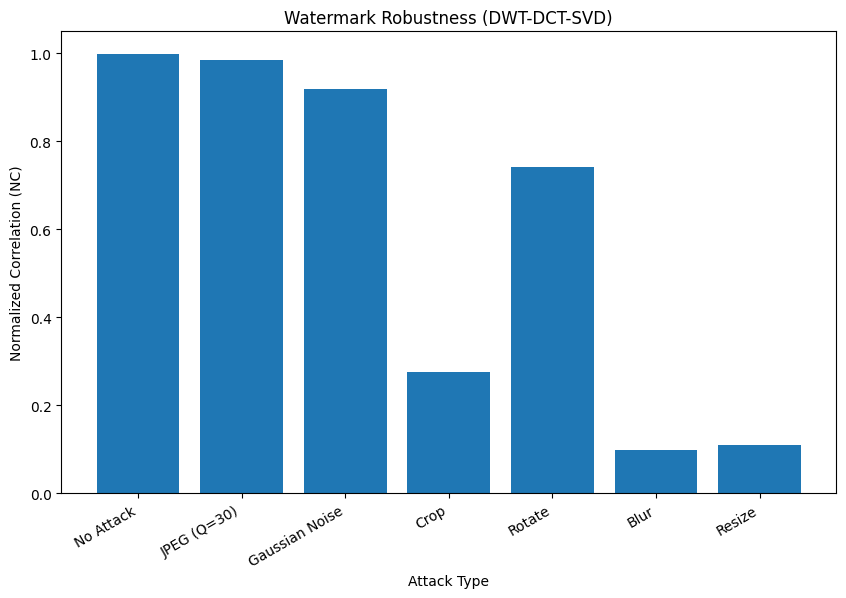

In [25]:
import matplotlib.pyplot as plt
from hybrid_DWT_DCT_SVD import embed_dwt_dct_svd, extract_dwt_dct_svd
from evaluation_metrics import evaluate_nc
import attack_function as attacks

cover_img = cv2.imread("cover5.jpg")
watermark_img = cv2.imread("logo4.png", cv2.IMREAD_GRAYSCALE)

# === Step 1: Embed watermark ===
watermarked_img, key = embed_dwt_dct_svd(cover_img, watermark_img, alpha=0.05)

# === Step 2: Define attack functions ===
attack_funcs = {
    "No Attack": lambda img: img,
    "JPEG (Q=30)": lambda img: attacks.jpeg_compression(img, quality=30),
    "Gaussian Noise": lambda img: attacks.add_gaussian_noise(img, var=0.01),
    "Crop": lambda img: attacks.crop_center(img, crop_ratio=0.8),
    "Rotate": lambda img: attacks.rotate_image(img, angle=15),
    "Blur": lambda img: attacks.blur_image(img, ksize=5),
    "Resize": lambda img: attacks.resize_attack(img, scale=0.5),
}

# === Step 3: Run attacks, extract, and compute NC ===
nc_scores = {}
for name, attack_fn in attack_funcs.items():
    attacked = attack_fn(watermarked_img)
    extracted = extract_dwt_dct_svd(attacked, key)  # unpack tuple
    nc = evaluate_nc(watermark_img, extracted)
    nc_scores[name] = nc

# === Step 4: Plot bar chart ===
plt.figure(figsize=(10, 6))
plt.bar(nc_scores.keys(), nc_scores.values())
plt.ylabel("Normalized Correlation (NC)")
plt.xlabel("Attack Type")
plt.title("Watermark Robustness (DWT-DCT-SVD)")
plt.xticks(rotation=30, ha='right')
plt.ylim(0, 1.05)
plt.show()


## Shek Jun Yi
Patchwork

In [ ]:
%%writefile patchwork.py
import numpy as np
from PIL import Image
import hashlib

def sha_seed(key: str) -> int:
    h = hashlib.sha256(key.encode("utf-8")).digest()
    return int.from_bytes(h[:8], "big", signed=False)

def default_pairs_per_bit(H, W):
    N = H * W
    # keep a reasonable number of pairs per bit for robustness
    return max(200, int(0.002 * N))

def embed_logo_into_image(image_pil, logo_pil, secret_key="secret",
                          width=64, height=64, threshold=128, delta=4.0,
                          pairs_per_bit=None):
    """
    Embed a binary logo watermark into a cover image using Patchwork.
    Returns (watermarked_pil, binary_logo_preview_pil)
    """
    # --- Preprocess logo ---
    logo_gray = logo_pil.convert("L").resize((width, height), Image.LANCZOS)
    logo_bin = (np.array(logo_gray) > threshold).astype(np.uint8)  # 0/1
    logo_bin_pil = Image.fromarray((logo_bin * 255).astype(np.uint8), mode="L")

    # --- Convert cover to Y channel (float32) ---
    img_ycbcr = image_pil.convert("YCbCr")
    Y, Cb, Cr = img_ycbcr.split()
    Y = np.array(Y).astype(np.float32)
    H, W = Y.shape
    N = H * W
    flat = Y.reshape(-1)

    # --- pairs per bit ---
    if pairs_per_bit is None:
        pairs_per_bit = default_pairs_per_bit(H, W)
    total_bits = width * height

    base_seed = sha_seed(secret_key)
    STEP = 1315423911

    # We'll modify a copy of flat so original remains untouched
    flat_wm = flat.copy()

    # For each bit, sample pairs and apply delta to many pairs (statistical embedding)
    for bit_index, bit in enumerate(logo_bin.flatten()):
        # per-bit RNG to decorrelate positions between bits
        seed = (base_seed ^ (bit_index * STEP)) & ((1 << 64) - 1)
        rng = np.random.default_rng(seed)

        # choose indices (allow replacement if too many needed)
        need = pairs_per_bit * 2
        replace = need > N
        idx = rng.choice(N, size=need, replace=replace)
        a = idx[:pairs_per_bit]
        b = idx[pairs_per_bit:]

        if bit == 1:
            flat_wm[a] += delta
            flat_wm[b] -= delta
        else:
            flat_wm[a] -= delta
            flat_wm[b] += delta

    # clip at the end and rebuild image
    Y_emb = np.clip(flat_wm, 0, 255).astype(np.uint8).reshape(H, W)
    watermarked_pil = Image.merge("YCbCr", (Image.fromarray(Y_emb), Cb, Cr)).convert("RGB")

    return watermarked_pil, logo_bin_pil

def extract_from_image(image_pil, secret_key="secret",
                       width=64, height=64, delta=4.0, pairs_per_bit=None):
    """
    Extract binary logo watermark from a watermarked image.
    Returns PIL grayscale image (0/255).
    """
    img_ycbcr = image_pil.convert("YCbCr")
    Y, _, _ = img_ycbcr.split()
    Y = np.array(Y).astype(np.float32)
    H, W = Y.shape
    N = H * W
    flat = Y.reshape(-1)

    if pairs_per_bit is None:
        pairs_per_bit = default_pairs_per_bit(H, W)
    total_bits = width * height

    base_seed = sha_seed(secret_key)
    STEP = 1315423911

    bits = np.zeros(total_bits, dtype=np.uint8)

    for bit_index in range(total_bits):
        seed = (base_seed ^ (bit_index * STEP)) & ((1 << 64) - 1)
        rng = np.random.default_rng(seed)

        need = pairs_per_bit * 2
        replace = need > N
        idx = rng.choice(N, size=need, replace=replace)
        a = idx[:pairs_per_bit]
        b = idx[pairs_per_bit:]

        stat = float(np.sum(flat[a] - flat[b]))
        bits[bit_index] = 1 if stat > 0 else 0

    logo_bin = (bits.reshape((height, width)) * 255).astype(np.uint8)
    extracted_pil = Image.fromarray(logo_bin, mode="L")
    return extracted_pil


Writing patchwork.py


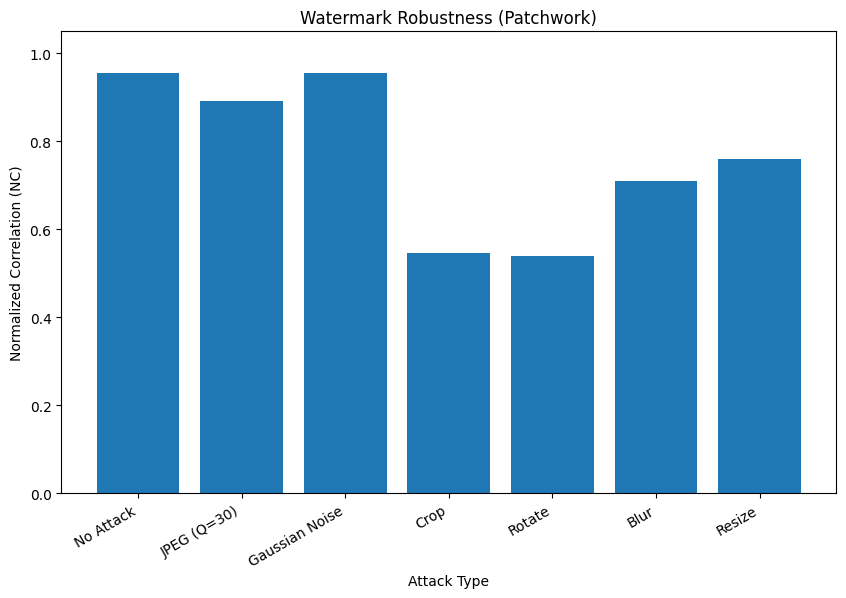

In [27]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from patchwork import embed_logo_into_image, extract_from_image  # Import your patchwork functions
from evaluation_metrics import evaluate_nc
import attack_function as attacks

# Load cover image and watermark (OpenCV loads as numpy.ndarray)
cover_img = cv2.imread("cover5.jpg")
watermark_img = cv2.imread("logo4.png", cv2.IMREAD_GRAYSCALE)

# Convert the images from numpy.ndarray to PIL Image
cover_img_pil = Image.fromarray(cv2.cvtColor(cover_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
watermark_img_pil = Image.fromarray(watermark_img)  # The watermark is already grayscale

# === Step 1: Embed watermark using Patchwork ===
secret_key = "secret"  # Define your secret key for watermarking
width = 64
height = 64
threshold = 128
delta = 4.0
watermarked_img, logo_bin_pil = embed_logo_into_image(cover_img_pil, watermark_img_pil, secret_key=secret_key, width=width, height=height, threshold=threshold, delta=delta)

# === Step 2: Define attack functions ===
attack_funcs = {
    "No Attack": lambda img: img,
    "JPEG (Q=30)": lambda img: attacks.jpeg_compression(img, quality=30),
    "Gaussian Noise": lambda img: attacks.add_gaussian_noise(img, var=0.01),
    "Crop": lambda img: attacks.crop_center(img, crop_ratio=0.8),
    "Rotate": lambda img: attacks.rotate_image(img, angle=15),
    "Blur": lambda img: attacks.blur_image(img, ksize=5),
    "Resize": lambda img: attacks.resize_attack(img, scale=0.5),
}

# === Step 3: Run attacks, extract watermark, and compute NC ===
nc_scores = {}
for name, attack_fn in attack_funcs.items():
    attacked = attack_fn(np.array(watermarked_img))  # Convert watermarked_img to NumPy array before applying attack

    # Convert the attacked image back to PIL format before passing to extract_from_image
    attacked_pil = Image.fromarray(cv2.cvtColor(attacked, cv2.COLOR_BGR2RGB))  # Convert back to PIL RGB
    extracted = extract_from_image(attacked_pil, secret_key=secret_key, width=width, height=height, delta=delta)  # Extract the watermark

    # Convert extracted image from PIL to NumPy array for NC evaluation
    extracted_np = np.array(extracted)
    nc = evaluate_nc(watermark_img, extracted_np)  # Calculate Normalized Correlation (NC)
    nc_scores[name] = nc  # Store the NC value for each attack

# === Step 4: Plot bar chart of NC scores ===
plt.figure(figsize=(10, 6))
plt.bar(nc_scores.keys(), nc_scores.values())
plt.ylabel("Normalized Correlation (NC)")
plt.xlabel("Attack Type")
plt.title("Watermark Robustness (Patchwork)")
plt.xticks(rotation=30, ha='right')
plt.ylim(0, 1.05)  # Limit y-axis to range [0, 1]
plt.show()

## Chew Zhan Zhe
Hybrid DWT-DCT-SVD

In [ ]:
%%writefile hybrid_DWT_DCT_SVD.py
import numpy as np
import cv2
import pywt

# ---------- Small utilities ----------

def _to_float01(img):
    """Ensure image is float32 in [0,1]."""
    img = img.astype(np.float32)
    if img.max() > 1.0:
        img /= 255.0
    img = np.clip(img, 0.0, 1.0)
    return img

def _gray_float01(img):
    """Convert to single-channel float32 [0,1]."""
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return _to_float01(img)

def _cover_to_ycbcr(cover01):
    """Convert BGR [0,1] to YCbCr and return (Y, Cb, Cr)."""
    cover_255 = (cover01 * 255.0).astype(np.uint8)
    ycbcr = cv2.cvtColor(cover_255, cv2.COLOR_BGR2YCrCb)
    ycbcr = ycbcr.astype(np.float32) / 255.0
    Y = ycbcr[..., 0]
    Cr = ycbcr[..., 1]
    Cb = ycbcr[..., 2]
    return Y, Cb, Cr

def _ycbcr_to_cover(Y, Cb, Cr):
    """Back to BGR [0,1]."""
    stack = np.stack([Y, Cr, Cb], axis=-1)
    stack_255 = np.clip(stack * 255.0, 0, 255).astype(np.uint8)
    bgr = cv2.cvtColor(stack_255, cv2.COLOR_YCrCb2BGR).astype(np.float32) / 255.0
    return np.clip(bgr, 0.0, 1.0)

def _dct2(a):
    """2D DCT using OpenCV (expects float32)."""
    return cv2.dct(a)

def _idct2(A):
    """2D inverse DCT using OpenCV (expects float32)."""
    return cv2.idct(A)

def _subband_tuple_index(name):
    """
    Map subband name to index in pywt.dwt2's detail tuple (LH, HL, HH).
    name: 'LH', 'HL', or 'HH'
    """
    m = {'LH': 0, 'HL': 1, 'HH': 2}
    if name not in m:
        raise ValueError("subband must be one of {'LH','HL','HH'}")
    return m[name]

# ---------- Embedding function ----------

def embed_dwt_dct_svd(
    cover_img,
    watermark_img,
    alpha=0.05,
    wavelet='haar',
    subband='HL',
):
    """
    Hybrid DWT-DCT-SVD watermark embedding on the Y channel (YCbCr).
    Args:
        cover_img: np.ndarray HxWxC (BGR) or HxW (grayscale). dtype uint8 or float.
        watermark_img: np.ndarray HxW or HxWxC; any type. Will be converted to grayscale float [0,1].
        alpha: embedding strength (float). Increase for stronger watermark/robustness, lower for fidelity.
        wavelet: wavelet name for pywt (e.g., 'haar', 'db2', ...).
        subband: one of {'LH','HL','HH'} to embed into details.
    Returns:
        watermarked_img (np.uint8 BGR),
        key (dict) containing everything needed for extraction.
    """
    # ---- Normalize / split channels ----
    if cover_img.ndim == 2:
        cover_bgr01 = cv2.cvtColor(cover_img, cv2.COLOR_GRAY2BGR).astype(np.float32)
        cover_bgr01 = _to_float01(cover_bgr01)
    else:
        cover_bgr01 = _to_float01(cover_img)

    Y, Cb, Cr = _cover_to_ycbcr(cover_bgr01)

    # Single-level DWT on Y
    LL, (LH, HL, HH) = pywt.dwt2(Y, wavelet=wavelet)

    # Pick subband to embed
    idx = _subband_tuple_index(subband)
    details = [LH.copy(), HL.copy(), HH.copy()]
    host_sub = details[idx].astype(np.float32)

    # DCT + SVD on host subband
    H_dct = _dct2(host_sub)
    Uh, Sh, Vh_t = np.linalg.svd(H_dct, full_matrices=False)  # Vh_t is V^T

    # Prepare watermark to the same size
    wm_gray = _gray_float01(watermark_img)
    wm_resized = cv2.resize(wm_gray, (host_sub.shape[1], host_sub.shape[0]), interpolation=cv2.INTER_AREA)

    # DCT + SVD on watermark
    W_dct = _dct2(wm_resized.astype(np.float32))
    Uw, Sw, Vw_t = np.linalg.svd(W_dct, full_matrices=False)

    # Embed in singular values
    Sh_emb = Sh + alpha * Sw

    # Recompose modified subband
    H_dct_emb = (Uh @ np.diag(Sh_emb) @ Vh_t).astype(np.float32)
    host_sub_emb = _idct2(H_dct_emb)

    # Place back the modified subband
    details[idx] = host_sub_emb
    LH_emb, HL_emb, HH_emb = details

    # Inverse DWT to reconstruct Y'
    Y_emb = pywt.idwt2((LL, (LH_emb, HL_emb, HH_emb)), wavelet=wavelet)

    # Match original Y size (pywt can produce slight size drift)
    Y_emb = cv2.resize(Y_emb.astype(np.float32), (Y.shape[1], Y.shape[0]), interpolation=cv2.INTER_CUBIC)
    Y_emb = np.clip(Y_emb, 0.0, 1.0)

    # Merge back to BGR
    watermarked01 = _ycbcr_to_cover(Y_emb, Cb, Cr)
    watermarked_u8 = np.clip(watermarked01 * 255.0, 0, 255).astype(np.uint8)

    # Build key for extraction
    key = {
        'alpha': float(alpha),
        'wavelet': wavelet,
        'subband': subband,
        'cover_hwc': cover_bgr01.shape,
        'host_U': Uh.astype(np.float32),
        'host_S': Sh.astype(np.float32),
        'host_Vt': Vh_t.astype(np.float32),
        'wm_U': Uw.astype(np.float32),
        'wm_Vt': Vw_t.astype(np.float32),
        'wm_original_shape': tuple(wm_gray.shape),
        'host_subband_shape': tuple(host_sub.shape),
    }

    return watermarked_u8, key

# ---------- Extracting function ----------

def extract_dwt_dct_svd(
    watermarked_img,
    key
):
    """
    Extract watermark using stored key.
    Args:
        watermarked_img: np.ndarray HxWxC or HxW (originally watermarked cover).
        key: dict returned by embed_dwt_dct_svd.
    Returns:
        extracted_wm (np.uint8, grayscale).
    """
    alpha = float(key['alpha'])
    wavelet = key['wavelet']
    subband = key['subband']

    # Ensure image format
    if watermarked_img.ndim == 2:
        watermarked_bgr01 = cv2.cvtColor(watermarked_img, cv2.COLOR_GRAY2BGR).astype(np.float32)
        watermarked_bgr01 = _to_float01(watermarked_bgr01)
    else:
        watermarked_bgr01 = _to_float01(watermarked_img)

    # Take Y channel
    Yw, Cb_w, Cr_w = _cover_to_ycbcr(watermarked_bgr01)

    # DWT on Yw
    LLw, (LH_w, HL_w, HH_w) = pywt.dwt2(Yw, wavelet=wavelet)

    idx = _subband_tuple_index(subband)
    details_w = [LH_w, HL_w, HH_w]
    host_sub_w = details_w[idx].astype(np.float32)

    # DCT + SVD on watermarked subband
    Hw_dct = _dct2(host_sub_w)
    Uw_h, Sw_h, Vw_h_t = np.linalg.svd(Hw_dct, full_matrices=False)

    # Recover singular values of watermark: Sw_est = (Sw_h - Sh) / alpha
    Sh = key['host_S']
    Sw_est = (Sw_h - Sh) / (alpha + 1e-12)

    # Recompose watermark in DCT domain using stored wm_U, wm_Vt
    Uw = key['wm_U']
    Vw_t = key['wm_Vt']
    W_dct_est = (Uw @ np.diag(Sw_est) @ Vw_t).astype(np.float32)

    # Inverse DCT to spatial domain
    wm_est = _idct2(W_dct_est)
    wm_est = np.clip(wm_est, 0.0, 1.0)

    # Resize back to original watermark size
    H0, W0 = key['wm_original_shape']
    wm_est = cv2.resize(wm_est, (W0, H0), interpolation=cv2.INTER_CUBIC)

    # Convert to 0-255 uint8 for presentation
    wm_est_u8 = np.clip(wm_est * 255.0, 0, 255).astype(np.uint8)
    return wm_est_u8


Writing hybrid_DWT_DCT_SVD.py


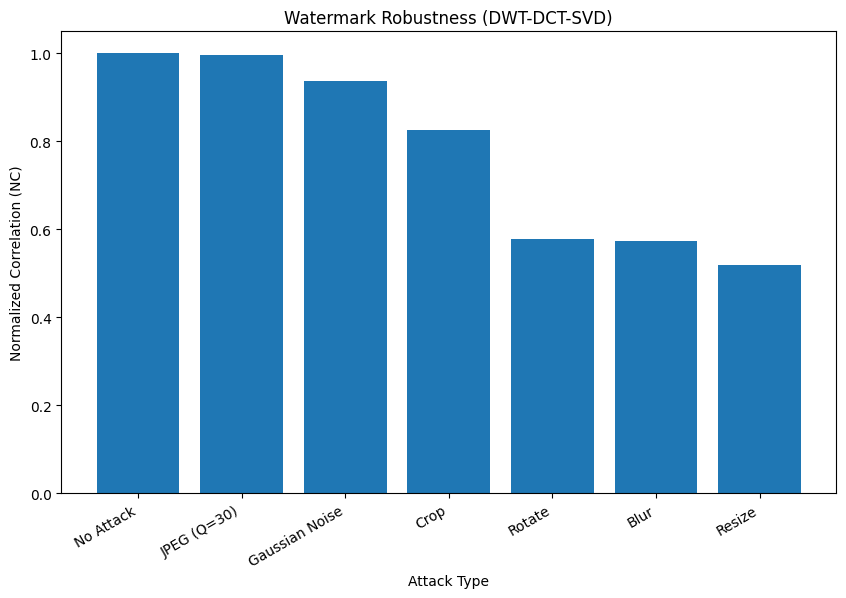

In [ ]:
import matplotlib.pyplot as plt
from hybrid_DWT_DCT_SVD import embed_dwt_dct_svd, extract_dwt_dct_svd
from evaluation_metrics import evaluate_nc
import attack_function as attacks

cover_img = cv2.imread("cover5.jpg")
watermark_img = cv2.imread("logo3.png", cv2.IMREAD_GRAYSCALE)

# === Step 1: Embed watermark ===
watermarked_img, key = embed_dwt_dct_svd(cover_img, watermark_img, alpha=0.05)

# === Step 2: Define attack functions ===
attack_funcs = {
    "No Attack": lambda img: img,
    "JPEG (Q=30)": lambda img: attacks.jpeg_compression(img, quality=30),
    "Gaussian Noise": lambda img: attacks.add_gaussian_noise(img, var=0.01),
    "Crop": lambda img: attacks.crop_center(img, crop_ratio=0.8),
    "Rotate": lambda img: attacks.rotate_image(img, angle=15),
    "Blur": lambda img: attacks.blur_image(img, ksize=5),
    "Resize": lambda img: attacks.resize_attack(img, scale=0.5),
}

# === Step 3: Run attacks, extract, and compute NC ===
nc_scores = {}
for name, attack_fn in attack_funcs.items():
    attacked = attack_fn(watermarked_img)
    extracted = extract_dwt_dct_svd(attacked, key)  # unpack tuple
    nc = evaluate_nc(watermark_img, extracted)
    nc_scores[name] = nc

# === Step 4: Plot bar chart ===
plt.figure(figsize=(10, 6))
plt.bar(nc_scores.keys(), nc_scores.values())
plt.ylabel("Normalized Correlation (NC)")
plt.xlabel("Attack Type")
plt.title("Watermark Robustness (DWT-DCT-SVD)")
plt.xticks(rotation=30, ha='right')
plt.ylim(0, 1.05)
plt.show()


# Streamlit App

In [ ]:
!pip install -q streamlit pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 106.1 MB/s eta 0:00:00


In [28]:
%%writefile app.py
import streamlit as st
import numpy as np
from PIL import Image
from io import BytesIO
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from hybrid_DWT_DCT_SVD import embed_dwt_dct_svd, extract_dwt_dct_svd
from SIFT import FixedSIFTWatermarking
from DCT import CleanDCTWatermarking
from DWT import DWTWatermark
from patchwork import embed_logo_into_image, extract_from_image
from attack_function import (
    jpeg_compression,
    add_gaussian_noise,
    crop_center,
    rotate_image,
    blur_image,
    resize_attack
)
from evaluation_metrics import evaluate_psnr_ssim, evaluate_nc

st.set_page_config(page_title="Watermarking", layout="wide")
st.title("Watermarking")

# Session state
if "cover_img" not in st.session_state:
  st.session_state.cover_img = None
if "wm_img" not in st.session_state:
  st.session_state.wm_img = None
if "student_id" not in st.session_state:
  st.session_state.student_id = None
if "artwork_title" not in st.session_state:
  st.session_state.artwork_title = None
if "watermarked" not in st.session_state:
  st.session_state.watermarked = None
if "key" not in st.session_state:
  st.session_state.key = None
if "extracted" not in st.session_state:
  st.session_state.extracted = None
if "wm_preview" not in st.session_state:
  st.session_state.wm_preview = None

# ALL Algorithms
st.sidebar.header("1) Watermark Algorithm")
prev_algorithm = st.session_state.get("prev_algorithm", None)
wm_algorithm = st.sidebar.selectbox(
      "Choose watermark algorithm",
      ["Hybrid DCT-DWT-SVD", "SIFT", "DCT", "DWT", "Patchwork"]
    )
# If algorithm changed → reset everything
if prev_algorithm != wm_algorithm:
  st.session_state.watermarked = None
  st.session_state.extracted = None
  st.session_state.key = None
  st.session_state.cover_img = None
  st.session_state.wm_img = None
  st.session_state.prev_algorithm = wm_algorithm

st.sidebar.header("2) Input")
cover_file = st.sidebar.file_uploader("Original image", type=["jpg","jpeg","png"])

if cover_file is not None:
    cover_img = Image.open(cover_file).convert("RGB")
    st.session_state.cover_img = np.array(cover_img)
else:
    st.session_state.cover_img = None

if wm_algorithm == "SIFT":
  st.session_state.student_id = st.sidebar.text_input("Student ID", value="123456")
  st.session_state.artwork_title = st.sidebar.text_input("Artwork Title", value="MyArtwork")
else:
  wm_file = st.sidebar.file_uploader("Watermark", type=["jpg","jpeg","png"])
  if wm_file is not None:
    st.session_state.wm_img = np.array(Image.open(wm_file).convert("L"))
  else:
    st.session_state.wm_img = None

tab_embed, tab_attack, tab_extract = st.tabs(["Embed", "Attack", "Extract"])

# embed tab
with tab_embed:
  st.subheader("Embed Watermark")
  col1, plus, col2, equal, col3 = st.columns([3, 1, 3, 1,3])

  with col1:
    st.write("**Original image**")
    if st.session_state.cover_img is not None:
        st.image(st.session_state.cover_img, use_container_width=True)
    else:
        st.info("Upload original image in the sidebar.")

  with col2:
    st.write("**Watermark**")
    if wm_algorithm == "SIFT":
      st.write(f"", st.session_state.student_id)
      st.write(f"", st.session_state.artwork_title)
    else:
      if st.session_state.wm_img is not None:
        st.image(st.session_state.wm_img, use_container_width=True, clamp=True)
      else:
        st.info("Upload watermark in the sidebar.")

  # if st.session_state.watermarked is None:
  if st.button("🔐 Embed now"):
    if st.session_state.cover_img is None:
      st.error("Please upload an original image.")
    else:
      # 1) SIFT
      if wm_algorithm == "SIFT":
        if st.session_state.student_id is None or st.session_state.artwork_title is None:
          st.error("Please enter student ID and artwork title.")
        else:
          watermarker = FixedSIFTWatermarking(key=42, strength=25)
          watermarked, embedding_info = watermarker.embed_watermark_fixed(
            st.session_state.cover_img,
            st.session_state.student_id,
            st.session_state.artwork_title
          )
          st.session_state.watermarked = watermarked
          st.session_state.key = embedding_info

          with plus:
            st.markdown(
              "<div style='text-align:center; font-size:40px; line-height:350px;'>+</div>",
              unsafe_allow_html=True
            )

          with equal:
            st.markdown(
              "<div style='text-align:center; font-size:40px; line-height:350px;'>=</div>",
              unsafe_allow_html=True
            )

          with col3:
            st.write("**Watermarked image**")
            st.image(st.session_state.watermarked, use_container_width=True)

          st.success("✅ Watermark embedded successfully!")
          psnr, ssim = evaluate_psnr_ssim(st.session_state.cover_img, st.session_state.watermarked)
          st.subheader("Evaluation on **Original Image vs. Watermarked Image**")
          st.write(f"PSNR: {psnr:.2f}")
          st.write(f"SSIM: {ssim:.4f}")
          with st.expander("ℹ️ About PSNR and SSIM"):
            st.markdown("""
            **PSNR (Peak Signal-to-Noise Ratio)**
            - Measures the **quality of the watermarked (or attacked) image** compared to the original cover.
            - Higher = Better quality.
            - > 40 dB → Excellent | 30–40 dB → Good | < 30 dB → Noticeable distortion

            **SSIM (Structural Similarity Index)**
            - Measures the **visual similarity** between two images (structure, brightness, contrast).
            - Range: 0 to 1
            - Closer to 1 = More similar
            """)


      else:
        if st.session_state.wm_img is None:
          st.error("Please upload a watermark image.")
        else:
          # hybrid dwt-dct-svd
          if wm_algorithm == "Hybrid DCT-DWT-SVD":
            watermarked, key = embed_dwt_dct_svd(
              st.session_state.cover_img,
              st.session_state.wm_img,
              alpha=0.05,
              wavelet="haar",
              subband="HL"
            )
            st.session_state.watermarked = watermarked
            st.session_state.key = key

          # dct
          elif wm_algorithm == "DCT":
            watermarker = CleanDCTWatermarking(
              block_size=8,
              quantization_step=16,
              embedding_strength=1.0
            )
            watermarked, processed_wm = watermarker.embed_watermark(
              st.session_state.cover_img,
              st.session_state.wm_img
            )
            st.session_state.watermarked = watermarked
            st.session_state.key = processed_wm

          #dwt
          elif wm_algorithm == "DWT":
            watermarker = DWTWatermark(alpha=0.03)
            watermarked, wm_resized = watermarker.embed(
              st.session_state.cover_img,
              st.session_state.wm_img
            )
            st.session_state.watermarked = watermarked
            st.session_state.key = st.session_state.cover_img

          #patchwork
          elif wm_algorithm == "Patchwork":
            wm_pil = Image.fromarray(st.session_state.wm_img).convert("RGB")
            cover_pil = Image.fromarray(st.session_state.cover_img).convert("RGB")
            watermarked_pil, preview_logo = embed_logo_into_image(
              cover_pil,
              wm_pil,
              secret_key="secret",
              width=64,
              height=64,
              threshold=128,
              delta=4.0
            )
            st.session_state.watermarked = np.array(watermarked_pil)
            st.session_state.key = "secret"
            st.session_state.wm_preview = np.array(preview_logo)

          else:
            st.error("Invalid watermark algorithm selected.")

          with plus:
            st.markdown(
              "<div style='text-align:center; font-size:40px; line-height:350px;'>+</div>",
              unsafe_allow_html=True
            )

          with equal:
            st.markdown(
              "<div style='text-align:center; font-size:40px; line-height:350px;'>=</div>",
              unsafe_allow_html=True
            )

          with col3:
            st.write("**Watermarked image**")
            st.image(st.session_state.watermarked, use_container_width=True)

          st.success("✅ Watermark embedded successfully!")
          psnr, ssim = evaluate_psnr_ssim(st.session_state.cover_img, st.session_state.watermarked)
          st.subheader("Evaluation on **Original Image vs. Watermarked Image**")
          st.write(f"PSNR: {psnr:.2f}")
          st.write(f"SSIM: {ssim:.4f}")
          with st.expander("ℹ️ About PSNR and SSIM"):
            st.markdown("""
            **PSNR (Peak Signal-to-Noise Ratio)**
            - Measures the **quality of the watermarked (or attacked) image** compared to the original cover.
            - Higher = Better quality.
            - > 40 dB → Excellent | 30–40 dB → Good | < 30 dB → Noticeable distortion

            **SSIM (Structural Similarity Index)**
            - Measures the **visual similarity** between two images (structure, brightness, contrast).
            - Range: 0 to 1
            - Closer to 1 = More similar
            """)

# attack tab
with tab_attack:
  st.subheader("Attack Watermarked Image")

  if st.session_state.watermarked is None:
    st.info("Nothing to attack from yet.")
  else:
    attack_choice = st.selectbox(
      "Choose an attack method",
      ["None", "JPEG Compression", "Gaussian Noise", "Cropping", "Rotation", "Blur", "Resizing"]
    )
    col1, icon, col2, space1, space2 = st.columns([3, 1, 3, 1,3])

    with col1:
      st.write("**Watermarked image**")
      st.image(st.session_state.watermarked, use_container_width=True)

    if st.button("Attack"):
      if attack_choice != "None":
        wm_img = st.session_state.watermarked.copy()

        if attack_choice == "JPEG Compression":
            attacked = jpeg_compression(wm_img, quality=30)
        elif attack_choice == "Gaussian Noise":
            attacked = add_gaussian_noise(wm_img, var=0.01)
        elif attack_choice == "Cropping":
            attacked = crop_center(wm_img, crop_ratio=0.8)
        elif attack_choice == "Rotation":
            attacked = rotate_image(wm_img, angle=30)
        elif attack_choice == "Blur":
            attacked = blur_image(wm_img, ksize=5)
        elif attack_choice == "Resizing":
            attacked = resize_attack(wm_img, scale=0.5)

        st.session_state.watermarked = attacked

        with icon:
          st.markdown(
            "<div style='text-align:center; font-size:40px; line-height:350px;'>></div>",
            unsafe_allow_html=True
          )

        with col2:
          st.write("**Attacked Watermark Image**")
          st.image(st.session_state.watermarked, use_container_width=True, clamp=True)

        st.success("✅ Watermarked attacked successfully!")
        psnr, ssim = evaluate_psnr_ssim(wm_img, attacked)
        st.subheader("Evaluation on **Original Watermarked Image vs. Watermarked Image After Attack**")
        st.write(f"PSNR after attack: {psnr:.2f}")
        st.write(f"SSIM after attack: {ssim:.4f}")
        with st.expander("ℹ️ About PSNR and SSIM"):
            st.markdown("""
            **PSNR (Peak Signal-to-Noise Ratio)**
            - Measures the **quality of the watermarked (or attacked) image** compared to the original cover.
            - Higher = Better quality.
            - > 40 dB → Excellent | 30–40 dB → Good | < 30 dB → Noticeable distortion

            **SSIM (Structural Similarity Index)**
            - Measures the **visual similarity** between two images (structure, brightness, contrast).
            - Range: 0 to 1
            - Closer to 1 = More similar
            """)
      else:
        st.error("Please select an attack method.")

# extract tab
with tab_extract:
  st.subheader("Extract Watermark")
  col1, icon, col2, space1, space2 = st.columns([3, 1, 3, 1,3])

  if st.session_state.watermarked is None:
    st.info("Nothing to extract from yet.")
  else:
    with col1:
      st.write("**Watermarked image**")
      st.image(st.session_state.watermarked, use_container_width=True)

    if st.button("🧩 Extract"):
      # SIFT
      if wm_algorithm == "SIFT":
        watermarker = FixedSIFTWatermarking(key=42, strength=25)
        results = watermarker.detect_watermark_fixed(
          st.session_state.watermarked,
          st.session_state.student_id,
          st.session_state.artwork_title,
          embedding_info=st.session_state.key
        )
        st.session_state.extracted = results

        with icon:
          st.markdown(
            "<div style='text-align:center; font-size:40px; line-height:350px;'>></div>",
            unsafe_allow_html=True
          )

        with col2:
          st.write("**Watermarked Text Detected**")
          if results.get("detected", False):
            st.success(f"{results['student_id']}")
            st.success(f"{results['artwork_title']}")
          else:
            st.error("❌ No watermark text detected.")

        st.session_state.watermarked = None
        st.session_state.key = None
        st.success("✅ Watermark extracted successfully!")

      else:
        # hybrid dwt-dct-svd
        if wm_algorithm == "Hybrid DCT-DWT-SVD":
          extracted = extract_dwt_dct_svd(st.session_state.watermarked, st.session_state.key)
          st.session_state.extracted = extracted

        # dct
        elif wm_algorithm == "DCT":
          watermarker = CleanDCTWatermarking(
            block_size=8,
            quantization_step=16,
            embedding_strength=1.0
          )
          extracted = watermarker.extract_watermark(
            st.session_state.watermarked,
            st.session_state.key.shape if st.session_state.key is not None else None
          )
          st.session_state.extracted = (extracted * 255).astype(np.uint8)

        # dwt
        elif wm_algorithm == "DWT":
          watermarker = DWTWatermark(alpha=0.03)
          extracted = watermarker.extract(
            st.session_state.watermarked,
            st.session_state.key
          )
          st.session_state.extracted = extracted

        #patchwork
        elif wm_algorithm == "Patchwork":
          wm_pil = Image.fromarray(st.session_state.watermarked).convert("RGB")
          extracted_pil = extract_from_image(wm_pil, st.session_state.key)
          st.session_state.extracted = np.array(extracted_pil)

        else:
          st.error("Invalid watermark algorithm selected.")

        with icon:
          st.markdown(
            "<div style='text-align:center; font-size:40px; line-height:350px;'>></div>",
            unsafe_allow_html=True
          )

        with col2:
          st.write("**Extracted Watermark**")
          st.image(st.session_state.extracted, use_container_width=True, clamp=True)

        st.session_state.watermarked = None
        st.session_state.key = None
        st.success("✅ Watermark extracted successfully!")

        nc = evaluate_nc(st.session_state.wm_img, st.session_state.extracted)
        st.subheader("Evaluation on **Original Watermarked Image vs. Extracted Watermarked Image**")
        st.write(f"NC: {nc:.4f}")
        with st.expander("ℹ️ About NC"):
          st.markdown("""
          **NC (Normalized Correlation)**
          - Measures the **similarity between original and extracted watermark**.
          - Range: 0 to 1
          - Closer to 1 = Better extraction
          """)


Overwriting app.py


In [ ]:
!ngrok config add-authtoken 31hBleTo8jY8SqEN2IFrIReC26J_2iADsYpmMu9WwVziUUiYU

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok

!streamlit run app.py &> streamlit.log &

public_url = ngrok.connect(addr="8501", proto="http")

print(f"Streamlit app: {public_url}")

Streamlit app: NgrokTunnel: "https://ac0ed6ad00cb.ngrok-free.app" -> "http://localhost:8501"
